In [13]:
from SALib.plotting.bar import plot as barplot
from SALib.sample import saltelli, fast_sampler, morris as morris_sample
from SALib.analyze import sobol, fast, morris
from SALib.test_functions import Ishigami
import numpy as np
import math


In [14]:
# Define the model inputs
problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]
}

In [15]:
# Generate samples for SOBOL
param_values_sobol = saltelli.sample(problem, 1000)

In [16]:
Y_Ishigami_sobol = Ishigami.evaluate(param_values_sobol)

In [17]:
# SOBOL METHOD
Si_sobol = sobol.analyze(problem, Y_Ishigami_sobol, print_to_console=True)

Parameter S1 S1_conf ST ST_conf
x1 0.307975 0.056858 0.560137 0.085794
x2 0.447767 0.054847 0.438722 0.041347
x3 -0.004255 0.052905 0.242845 0.024708

Parameter_1 Parameter_2 S2 S2_conf
x1 x2 0.012205 0.087715
x1 x3 0.251526 0.102267
x2 x3 -0.009954 0.069689


In [18]:
#FAST - Fourier Amplitude Sensitivity Test
X_FAST = fast_sampler.sample(problem, 1000)

In [19]:
Y_FAST = Ishigami.evaluate(X_FAST)

In [20]:
Si_FAST = fast.analyze(problem, Y_FAST, print_to_console=True)

Parameter First Total
x1 0.315091 0.564279
x2 0.442379 0.469340
x3 0.000000 0.239239


In [21]:
#Samples for morris test
X_morris = morris_sample.sample(problem, 1000, num_levels=4)

In [22]:
Y_morris = Ishigami.evaluate(X_morris)

In [23]:
Si = morris.analyze(problem, X_morris, Y_morris, conf_level=0.95, print_to_console=True, num_levels=4)

Parameter                         Mu_Star         Mu    Mu_Star_Conf      Sigma
x1                                  7.754      7.754           0.385      6.252
x2                                  7.875      0.110           0.000      7.878
x3                                  5.911     -0.137           0.383      8.598


In [24]:
from scipy import integrate
import pylab as p

In [25]:
# Define the model inputs
problem = {
    'num_vars': 2,
    'names': ['alfa', 'beta'],
    'bounds': [[0.75, 1.25],
               [0.15, 0.25]]
}

In [30]:
# Generate samples
param_values = saltelli.sample(problem, 10)
simulationSteps = 100

In [27]:
def dX_dt(X, t, a, b, c, d):
    """ Return the growth rate of fox and rabbit populations. """
    return np.array([ a*X[0] - b*X[0]*X[1] ,
                  -c*X[1] + d*b*X[0]*X[1] ])

In [28]:
def model(values, step):
    Y = np.zeros([values.shape[0]])

    gamma = 1.5
    delta = 0.75

    for i, X in enumerate(values):
        x = 10
        y = 5
        PP = np.array([x, y])
        t = np.linspace(0, 15,  simulationSteps) 
        alfa = X[0]
        beta = X[1]
        
        PPafterT, infodict = integrate.odeint(dX_dt, PP, t, args=(alfa, beta, gamma, delta), full_output=True)

        Y[i] = PPafterT[step][0]
    return Y


[nan nan]
[0.32479892 0.43707445]
[0.2512345  0.50574835]
[0.18643948 0.56535841]
[0.12935248 0.61748258]
[0.07879665 0.66389052]
[0.03373477 0.7061796 ]
[-0.00660705  0.74555919]
[-0.04266248  0.78269777]
[-0.0744457   0.81757189]
[-0.10146498  0.8493082 ]
[-0.12267866  0.87607952]
[-0.13658419  0.89517223]
[-0.14151701  0.90333155]
[-0.13613228  0.89737636]
[-0.11989513  0.87490271]
[-0.09334187  0.83480031]
[-0.05797593  0.77737771]
[-0.01584729  0.70407838]
[0.03101764 0.61695033]
[0.0811639  0.51813412]
[0.1341121 0.4096264]
[0.19053471 0.29345644]
[0.25214014 0.17223774]
[0.32122958 0.04991737]
[ 0.39994343 -0.06751769]
[ 0.48928261 -0.17165519]
[ 0.5880748 -0.2519361]
[ 0.69214253 -0.29692434]
[ 0.79380141 -0.29643735]
[ 0.88085004 -0.24326165]
[ 0.93180017 -0.1323465 ]
[0.90373752 0.04087852]
[0.73579839 0.26557467]
[0.44829999 0.47560942]
[0.20047362 0.59769924]
[0.06966345 0.64937812]
[0.01034619 0.67619479]
[-0.02466134  0.69853402]
[-0.05649269  0.72124677]
[-0.09185418  0.

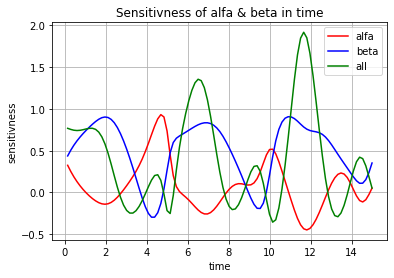

In [32]:
sensitivity = []
all = []
for i in range(simulationSteps):
    Y = model(param_values, i)
    Si = sobol.analyze(problem, Y, print_to_console=False)
    print(Si['S1'])
    sensitivity.append(Si['S1'])
    all.append(Si['S2'][0,1])

alfaSensitivity = [sensitivity[i][0] for i in range(simulationSteps)]
betaSensitivity = [sensitivity[i][1] for i in range(simulationSteps)]


t = np.linspace(0, 15,  simulationSteps)

f1 = p.figure()
p.plot(t, alfaSensitivity, 'r-', label='alfa')
p.plot(t, betaSensitivity, 'b-', label='beta')
p.plot(t, all, 'g-', label='all')
p.grid()
p.legend(loc='best')
p.xlabel('time')
p.ylabel('sensitivness')
p.title('Sensitivness of alfa & beta in time')
f1.savefig('pred-prey-alfa-beta.png')